# Getting started with using LF Energy for load flow simulations
Before first go, these commands should be run to make sure the environment is set

In [4]:
pip install uv

   ---------------------------------------- 0.0/17.6 MB ? eta -:--:--
   -------------------------- ------------- 11.8/17.6 MB 61.4 MB/s eta 0:00:01
   ---------------------------------------- 17.6/17.6 MB 61.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


I am using uv to handle dependecies etc. so commands are based on this.


In [35]:
#importing the libraries
import pypowsybl as pp
import pypowsybl.loadflow as lf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os #to save files to path
from pypowsybl._pypowsybl import VoltageInitMode, BalanceType
import json
SAVE_DIR = "Saved_results"
os.makedirs(SAVE_DIR, exist_ok=True)

In [6]:
# code to create the network
def create_9_bus_network():
    n = pp.network.create_ieee9() #creating the network based on built in network template
    buses=n.get_buses()
    print(buses)
    
    generators=n.get_generators()
    print(generators)
    
    lines=n.get_lines()
    print(lines)
    
    transformers=n.get_2_windings_transformers()
    print(transformers)
    
    loads=n.get_loads()
    print(loads)
    return n

In [7]:
#Standard way to simulate
# here we just use the built in default values for IEEE 9bus system and run an ordinary powerflow simulation....
n_base=create_9_bus_network()
results=pp.loadflow.run_ac(n_base)



      name  v_mag  v_angle  connected_component  synchronous_component  \
id                                                                       
VL1_0       104.0   0.0000                    0                      0   
VL1_1       102.5  -2.2160                    0                      0   
VL2_0       102.5   9.2800                    0                      0   
VL2_1       102.5   3.7197                    0                      0   
VL3_0       102.5   4.6647                    0                      0   
VL3_1       103.2   1.9667                    0                      0   
VL5_0        99.5  -3.9880                    0                      0   
VL6_0       101.2  -3.6870                    0                      0   
VL8_0       101.5   0.7275                    0                      0   

      voltage_level_id  
id                      
VL1_0              VL1  
VL1_1              VL1  
VL2_0              VL2  
VL2_1              VL2  
VL3_0              VL3  
VL3_1     

## Plotting results

### Topology


In [8]:
#We can plot the results in SLDs, where the arrows indicate direction and active(black) / reactive (blue) power flow. 
# SLDs can be printed for one voltage level (specified by 'VL1','VL2', 'VL3', 'VL5', 'VL6' or 'VL8' ). If SLD for non existing voltage level is tried this returs error ('VL4', 'VL7' or 'VL9')
n_base.get_single_line_diagram('VL1')

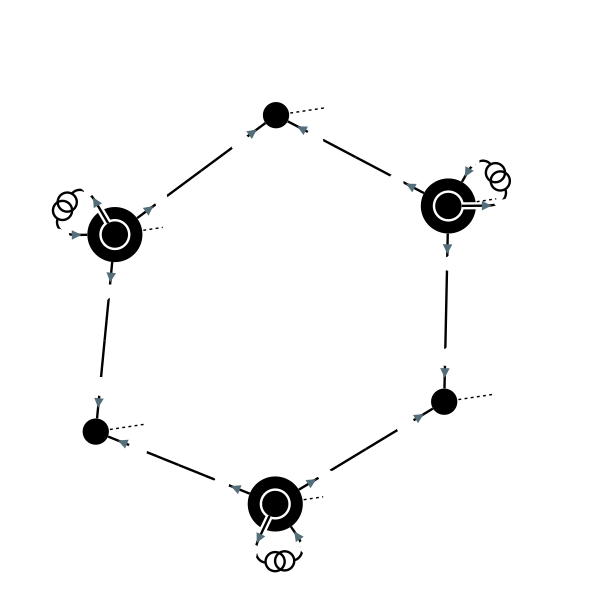

In [9]:
# You can also get the entire network plotted with get_network_area_diagram(). Here the voltage level can be specified, an this returs similar plot, but only for the specified voltage level. 
n_base.get_network_area_diagram()

In [10]:
# The plot can be saved to file as svg. 

path=os.path.join(SAVE_DIR,'ieee9_sld.svg') # using a specified folder to store the plots...
n_base.write_single_line_diagram_svg('VL1',path)

### Customizing the variables

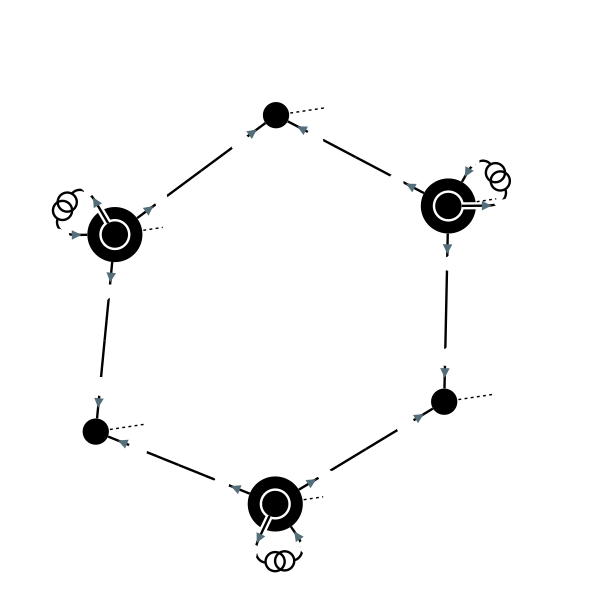

In [11]:
# We now compare the network results to eachother when changing some parameters...
# Load the standard IEEE 9-bus network

n2 = pp.network.create_ieee9() # we can call it n2 now, and keep the default as n_base
results1=pp.loadflow.run_ac(n2)# we run one more, just so we have some results to compare with,
voltages1=n2.get_buses().v_mag # we save the voltages for later (to compare...)
lines_current1=n2.get_lines()[['i1','i2']] # we save the lines for later (to compare...)
n2.get_network_area_diagram()



In [12]:
print(results1[0].distributed_active_power)
print(results1[0].slack_bus_results[0].active_power_mismatch)

0.0
-4.324395319610375e-06


In [13]:
# we can retrieve the components as variables so that we can save the original values for later (to compare changes)
# Get components as DataFrames for modification
buses = n2.get_buses()
generators = n2.get_generators()
loads = n2.get_loads()#[['p','q' ]]
lines = n2.get_lines()#[['r','x']]

In [14]:
#if names are needed it can be printed as this, we can also see some values, like r and x...
print(lines)

       name     r      x   g1        b1   g2        b2         p1         q1  \
id                                                                             
L7-8-0       0.85   7.20  0.0  0.000745  0.0  0.000745  76.379879  -0.797330   
L9-8-0       1.19  10.08  0.0  0.001045  0.0  0.001045  24.183416   3.119501   
L7-5-0       3.20  16.10  0.0  0.001530  0.0  0.001530  86.620150  -8.380823   
L9-6-0       3.90  17.00  0.0  0.001790  0.0  0.001790  60.816597 -18.074841   
L5-4-0       1.00   8.50  0.0  0.000880  0.0  0.000880 -40.679829 -38.687235   
L6-4-0       1.70   9.20  0.0  0.000790  0.0  0.000790 -30.537258 -16.543362   

                i1         p2         q2          i2 voltage_level1_id  \
id                                                                       
L7-8-0  429.924570 -75.904595 -10.704178  435.652249               VL2   
L9-8-0  136.367931 -24.095419 -24.295816  194.469402               VL3   
L7-5-0  489.814784 -84.320178 -11.312743  493.340101           

In [15]:
# Modify generator parameters
n2.update_generators(
    id='B1-G', 
    target_p=50,  # New active power setpoint (MW)
    target_v=108,  # New voltage setpoint (pu)
    min_p=50,
    max_p=250
)
#check that it has been updated
print(f"Old: {generators[['target_p','target_v']]}")
print(f"New: {n2.get_generators()[['target_p','target_v','bus_id']]}")

# Modify load parameters
n2.update_loads(
    id='B5-L',
    p0=200,  # Active power (MW)
    q0=30   # Reactive power (MVAr)
)
print(f"Old: {loads[['p0','q0']]}")
print(f"New: {n2.get_loads()[['p0','q0']]}")
# Modify line parameters
n2.update_lines(
    id='L5-4-0',
    r=0.1,  # New resistance (pu)
    x=0.5   # New reactance (pu)
)
print(f"Old: {lines[['r','x']]}")
print(f"New: {n2.get_lines()[['r','x']]}")

Old:        target_p  target_v
id                       
B1-G   71.64102     104.0
B2-G  163.00000     102.5
B3-G   85.00000     102.5
New:       target_p  target_v bus_id
id                             
B1-G      50.0     108.0  VL1_0
B2-G     163.0     102.5  VL2_0
B3-G      85.0     102.5  VL3_0
Old:          p0    q0
id               
B5-L  125.0  50.0
B6-L   90.0  30.0
B8-L  100.0  35.0
New:          p0    q0
id               
B5-L  200.0  30.0
B6-L   90.0  30.0
B8-L  100.0  35.0
Old:            r      x
id                 
L7-8-0  0.85   7.20
L9-8-0  1.19  10.08
L7-5-0  3.20  16.10
L9-6-0  3.90  17.00
L5-4-0  1.00   8.50
L6-4-0  1.70   9.20
New:            r      x
id                 
L7-8-0  0.85   7.20
L9-8-0  1.19  10.08
L7-5-0  3.20  16.10
L9-6-0  3.90  17.00
L5-4-0  0.10   0.50
L6-4-0  1.70   9.20


In [16]:
# Just another way of printing the values...
for index,row in lines.iterrows():
    print(f"{index}:r={round(row['r'],2)}, x={round(row['x'],2)}")

L7-8-0:r=0.85, x=7.2
L9-8-0:r=1.19, x=10.08
L7-5-0:r=3.2, x=16.1
L9-6-0:r=3.9, x=17.0
L5-4-0:r=1.0, x=8.5
L6-4-0:r=1.7, x=9.2


Distributed active power: 96.55627037723416
Active power mismatch: 6.094819560154008e-06


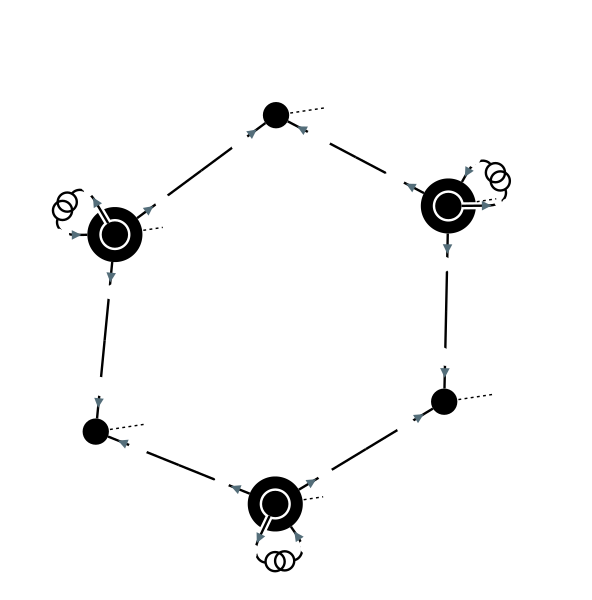

In [17]:
#re-run power flow with updated values
#n2 = pp.network.create_ieee9()
results2=pp.loadflow.run_ac(n2)
print(f'Distributed active power: {results2[0].distributed_active_power}')
print(f'Active power mismatch: {results2[0].slack_bus_results[0].active_power_mismatch}')
n2.get_network_area_diagram()

In [18]:
# Print results one item at a time
voltages2=n2.get_buses().v_mag
print(f'Initial results: {voltages1}')
print(f'next results: {voltages2}')
lines_current2=n2.get_lines()[['i1','i2']]
print(f'Initial lines current: {lines_current1}')  
print(f'next lines current: {lines_current2}')  
#print(voltages.loc['VL1_0'])

Initial results: id
VL1_0    104.000000
VL1_1    102.578841
VL2_0    102.500000
VL2_1    102.576939
VL3_0    102.500000
VL3_1    103.235296
VL5_0     99.563088
VL6_0    101.265434
VL8_0    101.588260
Name: v_mag, dtype: float64
next results: id
VL1_0    108.000000
VL1_1    105.790062
VL2_0    102.500000
VL2_1    104.084651
VL3_0    102.500000
VL3_1    104.055779
VL5_0    105.514151
VL6_0    103.714001
VL8_0    102.841037
Name: v_mag, dtype: float64
Initial lines current:                 i1          i2
id                            
L7-8-0  429.924570  435.652249
L9-8-0  136.367931  194.469402
L7-5-0  489.814784  493.340101
L9-6-0  354.824370  347.591012
L5-4-0  325.539102  263.990934
L6-4-0  198.010881  172.908376
next lines current:                 i1          i2
id                            
L7-8-0  446.948902  456.128324
L9-8-0  111.305438  162.407571
L7-5-0  500.684425  446.017790
L9-6-0  393.915379  353.459446
L5-4-0  697.270735  667.751907
L6-4-0  210.004661  156.475317


In [19]:
# Rather make a new variant to keep the initial variant
n2.clone_variant('InitialState', 'NewVariant')
n2.set_working_variant('NewVariant')

#First we can make a function to compare the two variants, and see what has changed.

def compare_variants(network, variant1, variant2, element_type='generators'): #Comparing two networks
    # Get data for first variant
    network.set_working_variant(variant1)
    if element_type == 'generators':
        df1 = network.get_generators()
    elif element_type == 'loads':
        df1 = network.get_loads()
    elif element_type == 'buses':
        df1 = network.get_buses()
    
    # Get data for second variant
    network.set_working_variant(variant2)
    if element_type == 'generators':
        df2 = network.get_generators()
    elif element_type == 'loads':
        df2 = network.get_loads()
    elif element_type == 'buses':
        df2 = network.get_buses()
    
    # Compare dataframes
    diff_mask = (df1 != df2).any(axis=1)
    differences = pd.concat([
        df1[diff_mask].add_suffix(f'_{variant1}'),
        df2[diff_mask].add_suffix(f'_{variant2}')
    ], axis=1)
    
    return differences



In [20]:
# Modify generator parameters
n2.update_generators(
    id='B1-G', 
    target_p=75,  # New active power setpoint (MW)
    target_v=106,  # New voltage setpoint (pu)
    min_p=50,
    max_p=250
)

# Modify load parameters
n2.update_loads(
    id='B5-L',
    p0=250,  # Active power (MW)
    q0=40   # Reactive power (MVAr)
)
# Modify line parameters
n2.update_lines(
    id='L5-4-0',
    r=0.15,  # New resistance (pu)
    x=0.45   # New reactance (pu)
)

#Lets now compare the two variants, and see what has changed.
gen_diff=compare_variants(n2, 'InitialState', 'NewVariant', element_type='generators')
load_diff=compare_variants(n2, 'InitialState', 'NewVariant', element_type='loads')

In [21]:
# run a new power flow simulation with singel slack bus instead of distributed slack bus
n2.set_working_variant('InitialState')
results3=lf.run_ac(n2, parameters=lf.Parameters(distributed_slack=True))
print(f'Distributed active power: {results3[0].distributed_active_power}')
print(f'Active power mismatch: {results3[0].slack_bus_results[0].active_power_mismatch}')
voltages3=n2.get_buses().v_mag
lines_current3=n2.get_lines()[['i1','i2']]
p3=n2.get_generators().p
#q3=n2.get_buses().q0

Distributed active power: 96.62515305761283
Active power mismatch: 6.355182535777715e-06


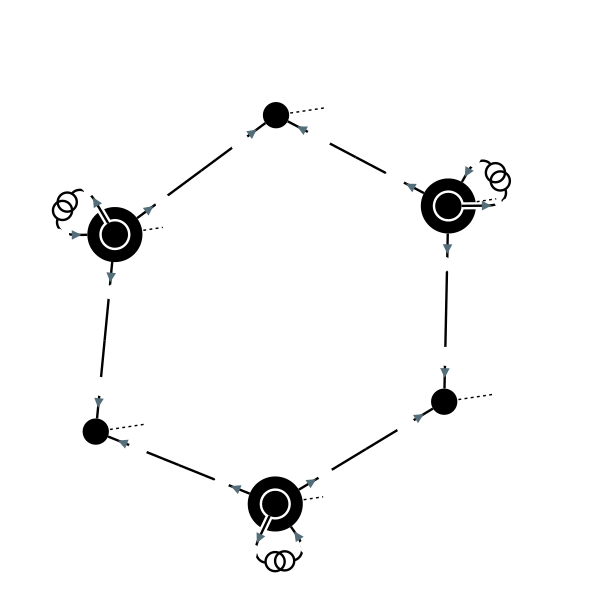

In [22]:
n2.get_network_area_diagram(depth=1)

In [23]:
print(f"Old: {voltages1}")
print(f"New: {voltages2}")
print(f"New2: {voltages3}")

print(f"Old: {lines_current1}")
print(f"New: {lines_current2}")
print(f"New2: {lines_current3}")


Old: id
VL1_0    104.000000
VL1_1    102.578841
VL2_0    102.500000
VL2_1    102.576939
VL3_0    102.500000
VL3_1    103.235296
VL5_0     99.563088
VL6_0    101.265434
VL8_0    101.588260
Name: v_mag, dtype: float64
New: id
VL1_0    108.000000
VL1_1    105.790062
VL2_0    102.500000
VL2_1    104.084651
VL3_0    102.500000
VL3_1    104.055779
VL5_0    105.514151
VL6_0    103.714001
VL8_0    102.841037
Name: v_mag, dtype: float64
New2: id
VL1_0    108.000000
VL1_1    105.799859
VL2_0    102.500000
VL2_1    104.077771
VL3_0    102.500000
VL3_1    104.055487
VL5_0    105.484208
VL6_0    103.719593
VL8_0    102.836594
Name: v_mag, dtype: float64
Old:                 i1          i2
id                            
L7-8-0  429.924570  435.652249
L9-8-0  136.367931  194.469402
L7-5-0  489.814784  493.340101
L9-6-0  354.824370  347.591012
L5-4-0  325.539102  263.990934
L6-4-0  198.010881  172.908376
New:                 i1          i2
id                            
L7-8-0  446.948902  456.128324


In [24]:
# Now we control which bus is the slack bus (this is not correct, and set all other gens to PQ buses...)
def set_slack_bus(network, gen_id):
    # Get generators DataFrame and its index
    generators_df = network.get_generators()
    all_gens = generators_df.index.tolist()
    
    # Verify generator exists
    if gen_id not in all_gens:
        raise ValueError(f"Generator {gen_id} not found. Available generators: {all_gens}")
    
    # Set voltage regulation off for all generators
    network.update_generators(
        id=all_gens,
        voltage_regulator_on=[False] * len(all_gens)
    )
    
    # Set specified generator as slack
    network.update_generators(
        id=[gen_id],
        voltage_regulator_on=[True],
        target_v=[400.0],
        target_p=[100.0]
    )

In [25]:
# Get current slack bus(es)
print("Before setting slack bus:")
print(n2.get_generators()[['name', 'voltage_regulator_on', 'bus_id']])
set_slack_bus(n2, 'B2-G')

print("\nAfter setting slack bus:")
print(n2.get_generators()[['name', 'voltage_regulator_on', 'bus_id']])



Before setting slack bus:
     name  voltage_regulator_on bus_id
id                                    
B1-G                       True  VL1_0
B2-G                       True  VL2_0
B3-G                       True  VL3_0

After setting slack bus:
     name  voltage_regulator_on bus_id
id                                    
B1-G                      False  VL1_0
B2-G                       True  VL2_0
B3-G                      False  VL3_0


In [26]:
#Rerun the power flow with the new slack bus
results4=pp.loadflow.run_ac(n2)
voltages4=n2.get_buses().v_mag
lines_current4=n2.get_lines()[['i1','i2']]
p4=n2.get_generators().p
#q4=n2.get_buses().q0
n2.get_network_area_diagram(depth=1)
print(f"Old: {voltages1}")
print(f"New: {voltages2}")
print(f"New2: {voltages3}")
print(f"New3: {voltages4}")
print(f"Old: {lines_current1}")
print(f"New: {lines_current2}")
print(f"New2: {lines_current3}")
print(f"New3: {lines_current4}")    


Old: id
VL1_0    104.000000
VL1_1    102.578841
VL2_0    102.500000
VL2_1    102.576939
VL3_0    102.500000
VL3_1    103.235296
VL5_0     99.563088
VL6_0    101.265434
VL8_0    101.588260
Name: v_mag, dtype: float64
New: id
VL1_0    108.000000
VL1_1    105.790062
VL2_0    102.500000
VL2_1    104.084651
VL3_0    102.500000
VL3_1    104.055779
VL5_0    105.514151
VL6_0    103.714001
VL8_0    102.841037
Name: v_mag, dtype: float64
New2: id
VL1_0    108.000000
VL1_1    105.799859
VL2_0    102.500000
VL2_1    104.077771
VL3_0    102.500000
VL3_1    104.055487
VL5_0    105.484208
VL6_0    103.719593
VL8_0    102.836594
Name: v_mag, dtype: float64
New3: id
VL1_0    108.000000
VL1_1    105.799859
VL2_0    102.500000
VL2_1    104.077771
VL3_0    102.500000
VL3_1    104.055487
VL5_0    105.484208
VL6_0    103.719593
VL8_0    102.836594
Name: v_mag, dtype: float64
Old:                 i1          i2
id                            
L7-8-0  429.924570  435.652249
L9-8-0  136.367931  194.469402
L7-5-

#Adding more simulation steps
Here we add more steps in the simulation

In [27]:
# Adding some load variations:
def create_ieee9_time_series(steps=5, p_set_gen2=163, p_set_gen3=85):
    # Create the IEEE 9-bus network
    network = pp.network.create_ieee9()
    
    # Define time steps
    snapshots = pd.date_range("2025-01-01 00:00", periods=steps, freq="h")
    
    # Define base loads and variation patterns
    base_loads = {
        'B5-L': {'p': 90, 'q': 30},
        'B6-L': {'p': 100, 'q': 35},
        'B8-L': {'p': 125, 'q': 50}
    }
    
    # Define oscillation patterns similar to PyPSA implementation
    base_patterns = {
        'B5-L': np.array([1, 1, 1, -1, -1]),
        'B6-L': np.array([0, 1, 1, -1, -1]),
        'B8-L': np.array([0, 0, 1, 0, -1])
    }
    
    variation = 0.1  # 30% variation
    
    # Store results for each time step
    results = {}
    load_values = {load_id: {'p': [], 'q': []} for load_id in base_loads.keys()}
    generator_values = {'B1-G': [], 'B2-G': [], 'B3-G': []}
    
    # Set generator values
    network.update_generators(id='B2-G', target_p=p_set_gen2)
    network.update_generators(id='B3-G', target_p=p_set_gen3)
    
    # Create and simulate each time step
    for step in range(min(steps, 5)):
        # Create a variant for this time step
        variant_id = f"step_{step}" # we have used the step_number as variant id
        network.clone_variant('InitialState',variant_id) # network is updated to include this variant...
        network.set_working_variant(variant_id) # here is where the equivalent to "snapshot" in pypsa is set, in powsybl it is called "working_variant"
        
        #with this working variant we can now make some changes to load, or to other grid characteristics
        # Update loads based on patterns
        for load_id, base_load in base_loads.items():
            pattern_value = base_patterns[load_id][step]
            p_value = base_load['p'] * (1 + variation * pattern_value)
            q_value = base_load['q'] * (1 + variation * pattern_value)
            
            network.update_loads(id=load_id, p0=p_value, q0=q_value)
            load_values[load_id]['p'].append(p_value)
            load_values[load_id]['q'].append(q_value)
        
        # Run load flow for this time step
        result = pp.loadflow.run_ac(network)
        results[step] = result
        
        # Get generator output for this time step
        generators = network.get_generators()
        for gen_id in ['B1-G', 'B2-G', 'B3-G']:
            #gen_data = generators[generators['id'] == gen_id]
            gen_data = generators[generators.index == gen_id]
            if not gen_data.empty:
                generator_values[gen_id].append(gen_data['p'].values[0])
        
        # Reset to base variant for next iteration
        network.set_working_variant("InitialState")
    
    return network, results, load_values, generator_values, snapshots



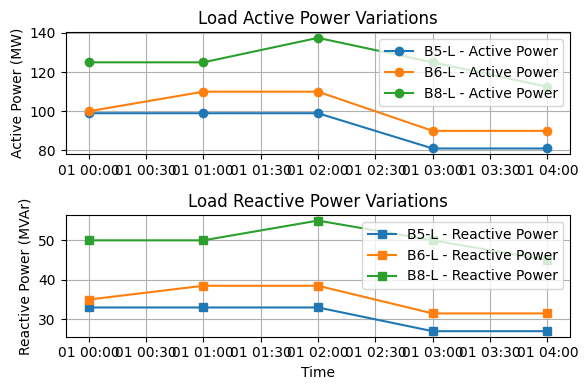

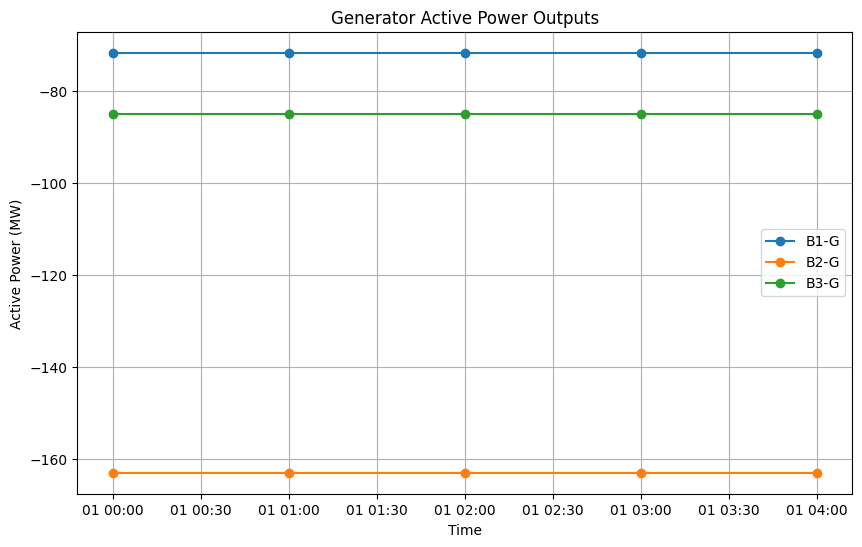

In [28]:
# We can now use the procedure above to create time series simulation
network, results, load_values, generator_values, snapshots = create_ieee9_time_series()

# Plot load variations
plt.figure(figsize=(6, 4))
plt.subplot(2, 1, 1)
for load_id, values in load_values.items():
    plt.plot(snapshots, values['p'], marker='o', label=f"{load_id} - Active Power")
plt.title('Load Active Power Variations')
plt.ylabel('Active Power (MW)')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
for load_id, values in load_values.items():
    plt.plot(snapshots, values['q'], marker='s', label=f"{load_id} - Reactive Power")
plt.title('Load Reactive Power Variations')
plt.xlabel('Time')
plt.ylabel('Reactive Power (MVAr)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot generator outputs
plt.figure(figsize=(10, 6))
for gen_id, values in generator_values.items():
    plt.plot(snapshots, values, marker='o', label=gen_id)
plt.title('Generator Active Power Outputs')
plt.xlabel('Time')
plt.ylabel('Active Power (MW)')
plt.legend()
plt.grid(True)
plt.show()

## Creating a network with several timesteps, where loads, generator setpoints and slack mode can be adjustet


In [29]:
#Creating the network
def create_ieee9_time_series_network(
        steps=5, 
        p_set_gen2=163, p_set_gen3=85,gen_max_p_factor=1.2,
        p_set_load5=90, p_set_load6=100, p_set_load8=125,
        q_set_load5=30, q_set_load6=35, q_set_load8=50,
        load_variation=0.1
        ):
    """
    Create IEEE 9-bus network and prepare time series variants with proper generator settings
    """
    # Create the IEEE 9-bus network
    network = pp.network.create_ieee9()
    
    # Get initial generator settings to preserve voltage setpoints
    initial_gens = network.get_generators()
    
    # Get Gen1's original target_p and set limits around it
    p_set_gen1 = initial_gens.loc['B1-G', 'target_p']
    
    # Update generators with complete settings
    network.update_generators(
        id=['B1-G'],
        target_p=[p_set_gen1],  # Keep original value
        min_p=[0.0],
        max_p=[p_set_gen1 * gen_max_p_factor],  # Allow 20% headroom
        voltage_regulator_on=[True],
        target_v=[initial_gens.loc['B1-G', 'target_v']]
    )
    
    network.update_generators(
        id=['B2-G'],
        target_p=[p_set_gen2],
        min_p=[0.0],
        max_p=[p_set_gen2 * gen_max_p_factor],
        voltage_regulator_on=[True],
        target_v=[initial_gens.loc['B2-G', 'target_v']]
    )
    
    network.update_generators(
        id=['B3-G'],
        target_p=[p_set_gen3],
        min_p=[0.0],
        max_p=[p_set_gen3 * gen_max_p_factor],
        voltage_regulator_on=[True],
        target_v=[initial_gens.loc['B3-G', 'target_v']]
    )
    # Define time steps
    snapshots = pd.date_range("2025-01-01 00:00", periods=steps, freq="h")
    
    # Define base loads and variation patterns
    base_loads = {
        'B5-L': {'p': p_set_load5, 'q': q_set_load5},
        'B6-L': {'p': p_set_load6, 'q': q_set_load6},
        'B8-L': {'p': p_set_load8, 'q': q_set_load8}
    }
    
    # Define oscillation patterns
    base_patterns = {
        'B5-L': np.array([1, 1, 1, -1, -1]),
        'B6-L': np.array([0, 1, 1, -1, -1]),
        'B8-L': np.array([0, 0, 1, 0, -1])
    }
    
    variation = load_variation  # 10% variation or per user input
    
    # Create variants for each time step
    for step in range(min(steps, 5)):
        variant_id = f"step_{step}"
        network.clone_variant("InitialState", variant_id)
        network.set_working_variant(variant_id)
        
        # Update loads based on patterns
        for load_id, base_load in base_loads.items():
            pattern_value = base_patterns[load_id][step]
            p_value = base_load['p'] * (1 + variation * pattern_value)
            q_value = base_load['q'] * (1 + variation * pattern_value)
            network.update_loads(id=load_id, p0=p_value, q0=q_value)
        
        network.set_working_variant("InitialState")
    
    return network, snapshots

# Returns a IEEE 9 bus network with default 5 timesteps, and default values for loads and generators

In [30]:
# Some helper functions to set parameters

def configure_slack_mode(network, mode='distributed', slack_bus_id=None, balance_method='P'):
    """
    Configure slack bus mode for load flow calculations with specific power balancing
    
    Parameters:
    -----------
    network : Network
        pypowsybl network object
    mode : str
        'distributed' - distribute slack across generators
        'single' - use single slack bus
    slack_bus_id : str, optional
        ID of bus to use as slack when mode='single'
    balance_method : str
        'P_MAX' - distribute proportional to generator max power
        'P' - distribute proportional to current generator power
        'MARGIN' - distribute proportional to remaining generator margin
        'LOAD' - distribute on loads
    """
    # Map balance methods to enum values
    balance_types = {
        'P_MAX': BalanceType.PROPORTIONAL_TO_GENERATION_P_MAX,
        'P': BalanceType.PROPORTIONAL_TO_GENERATION_P,
        'MARGIN': BalanceType.PROPORTIONAL_TO_GENERATION_REMAINING_MARGIN,
        'LOAD': BalanceType.PROPORTIONAL_TO_LOAD
    }
    
    # Base parameters with explicit distribution settings
    params = pp.loadflow.Parameters(
        voltage_init_mode=VoltageInitMode.UNIFORM_VALUES,
        transformer_voltage_control_on=True,
        use_reactive_limits=True,
        write_slack_bus=True,
        distributed_slack=True if mode.lower() == 'distributed' else False,
        balance_type=balance_types[balance_method],
        read_slack_bus=False  # Don't read existing slack bus configuration
    )
    
    # Add provider-specific parameters for better control
    if mode.lower() == 'distributed':
        params.provider_parameters = {
            'slackBusSelectionMode': 'MOST_MESHED',
            'balanceType': balance_method,
            'distributedSlack': 'true',
            'loadPowerFactorConstant': 'false',  # Allow power factor to vary
            'remainingPowerAdjustment': 'true',   # Enable power adjustment
            'computeMaximumMismatch': 'true'
        }
    elif mode.lower() == 'single':
        params.provider_parameters = {
            'slackBusSelectionMode': 'NAME' if slack_bus_id else 'MOST_MESHED',
            'slackBusesIds': slack_bus_id if slack_bus_id else '',
            'distributedSlack': 'false'
        }
    
    return params
#returns a network with the specified slack mode and parameters
#Older version, modified further down...
def set_line_current_limits_basic(network, line_limits):
    """
    Set permanent current limits for lines using operational limits.
    
    Parameters:
    -----------
    network : Network
        pypowsybl network object
    line_limits : dict
        Dictionary in format {line_id: (limit1, limit2)} where:
        - limit1: Current limit for side 1 (from-bus) in A
        - limit2: Current limit for side 2 (to-bus) in A
        Example: {'L7-8': (500, 500), 'L9-8': (400, 400)}
    
    Returns:
    --------
    Network
        Updated network with operational limits
    """
    element_ids = []
    sides = []
    values = []
    
    for line_id, (limit1, limit2) in line_limits.items():
        # Add limits for both sides of the line
        element_ids.extend([line_id, line_id])
        sides.extend(['ONE', 'TWO'])  # 'ONE' = from-bus, 'TWO' = to-bus
        values.extend([limit1, limit2])
    
    network.create_operational_limits(
        element_id=element_ids,
        side=sides,
        name=['PERMANENT']*len(element_ids),
        type=['CURRENT']*len(element_ids),
        value=values,
        acceptable_duration=[-1]*len(element_ids),  # -1 = permanent
        fictitious=[False]*len(element_ids)
    )
    
    return network

# returns a network with the specified line current limits


In [31]:
#Two ways to run the loadflow, one with default (distributed) slack and one with configurable slack bus.

def run_time_series_loadflow(network, snapshots,print_debugging=False):
    """
    Run load flow for time series with distributed slack (default behavior)
    
    Parameters:
    -----------
    network : Network
        pypowsybl network object
    snapshots : pd.DatetimeIndex
        Time points for simulation
    """
    # Initialize storage
    results = {}
    buses = network.get_buses()
    lines = network.get_lines()
    transformers = network.get_2_windings_transformers()
    
    # Initialize DataFrames
    bus_results = pd.DataFrame(
        index=snapshots,
        columns=pd.MultiIndex.from_product([
            buses.index,
            ['P (MW)', 'Q (MVAr)', 'V (pu)', 'Angle (deg)']
        ])
    )
    
    line_results = pd.DataFrame(
        index=snapshots,
        columns=pd.MultiIndex.from_product([
            list(lines.index) + list(transformers.index),
            ['P0 (MW)', 'P1 (MW)', 'Q0 (MVAr)', 'Q1 (MVAr)', 'I1 (A)', 'I2 (A)']
        ])
    )
    
    slack_bus_results = pd.DataFrame(
        index=snapshots,
        columns=['bus_id', 'P_mismatch (MW)', 'distributed_P (MW)']
    )
    
    for step in range(len(snapshots)):
        if print_debugging: print(f"\n=== Processing timestep {step} ===")
        variant_id = f"step_{step}"
        network.set_working_variant(variant_id)
        
        # Get initial generator state
        initial_gens = network.get_generators()
        if print_debugging:
            print("\nInitial generator states:")
            for idx, gen in initial_gens.iterrows():
                print(f"{idx}: P={gen['p']:.2f}, target_P={gen['target_p']:.2f}, "
                    f"voltage_reg={gen['voltage_regulator_on']}")
            
        # Run load flow
        result = pp.loadflow.run_ac(network)
        results[step] = result
        
        # Get updated generator state
        final_gens = network.get_generators()
        if print_debugging:
            print("\nFinal generator states:")
            for idx, gen in final_gens.iterrows():
                print(f"{idx}: P={gen['p']:.2f}, target_P={gen['target_p']:.2f}, "
                    f"voltage_reg={gen['voltage_regulator_on']}")
            
        # Calculate total power change
        total_gen_change = sum(final_gens['p'] - initial_gens['p'])
        
        # Store component results with detailed power tracking
        component_result = result[0]
        if component_result.slack_bus_results:
            slack_info = component_result.slack_bus_results[0]
                        
            slack_bus_results.loc[snapshots[step]] = {
                'bus_id': slack_info.id,
                'P_mismatch (MW)': slack_info.active_power_mismatch,
                'distributed_P (MW)': component_result.distributed_active_power
            }
            
            if print_debugging:
                #For debugging, print the slack bus results
                print(f"\nPower Balance Analysis:")
                print(f"Slack bus: {slack_info.id}")
                print(f"Power mismatch: {slack_info.active_power_mismatch:.2f} MW")
                print(f"Distributed power: {component_result.distributed_active_power:.2f} MW")
                print(f"Total generator change: {total_gen_change:.2f} MW")
                print(f"Load flow status: {component_result.status}")
                
        
        # Store bus results
        for bus_id in buses.index:
            bus = buses.loc[bus_id]
            voltage_level = network.get_voltage_levels()[
                network.get_voltage_levels().index == bus['voltage_level_id']
            ].iloc[0]
            
            bus_results.loc[snapshots[step], (bus_id, 'V (pu)')] = bus['v_mag'] / voltage_level['nominal_v']
            bus_results.loc[snapshots[step], (bus_id, 'Angle (deg)')] = bus['v_angle']
        
        # Store line results
        updated_lines = network.get_lines()
        for line_id in lines.index:
            line = updated_lines.loc[line_id]
            line_results.loc[snapshots[step], (line_id, 'P0 (MW)')] = line['p1']
            line_results.loc[snapshots[step], (line_id, 'P1 (MW)')] = line['p2']
            line_results.loc[snapshots[step], (line_id, 'Q0 (MVAr)')] = line['q1']
            line_results.loc[snapshots[step], (line_id, 'Q1 (MVAr)')] = line['q2']
            line_results.loc[snapshots[step], (line_id, 'I1 (A)')] = line['i1']
            line_results.loc[snapshots[step], (line_id, 'I2 (A)')] = line['i2']
        
        # Store transformer results
        updated_transformers = network.get_2_windings_transformers()
        for trafo_id in transformers.index:
            trafo = updated_transformers.loc[trafo_id]
            line_results.loc[snapshots[step], (trafo_id, 'P0 (MW)')] = trafo['p1']
            line_results.loc[snapshots[step], (trafo_id, 'P1 (MW)')] = trafo['p2']
            line_results.loc[snapshots[step], (trafo_id, 'Q0 (MVAr)')] = trafo['q1']
            line_results.loc[snapshots[step], (trafo_id, 'Q1 (MVAr)')] = trafo['q2']
        network.set_working_variant("InitialState")
    
    return results, bus_results, line_results, slack_bus_results

def run_time_series_loadflow_with_slack_modification(network, snapshots, slack_mode='distributed', 
                           slack_bus_id=None, balance_method='P',print_debugging=False):
    """
    Run load flow for time series with configurable slack handling
        
    Parameters:
    -----------
    network : Network
        pypowsybl network object
    snapshots : pd.DatetimeIndex
        Time points for simulation
    slack_mode : str
        'distributed' or 'single'
    slack_bus_id : str, optional
        ID of slack bus if using single mode
    """
        # Initialize storage
    results = {}
    buses = network.get_buses()
    lines = network.get_lines()
    transformers = network.get_2_windings_transformers()
    
    # Initialize DataFrames
    bus_results = pd.DataFrame(
        index=snapshots,
        columns=pd.MultiIndex.from_product([
            buses.index,
            ['P (MW)', 'Q (MVAr)', 'V (pu)', 'Angle (deg)']
        ])
    )
    
    line_results = pd.DataFrame(
        index=snapshots,
        columns=pd.MultiIndex.from_product([
            list(lines.index) + list(transformers.index),
            ['P0 (MW)', 'P1 (MW)', 'Q0 (MVAr)', 'Q1 (MVAr)', 'I1 (A)', 'I2 (A)']
        ])
    )
    
    # Add branch flow tracking
    slack_bus_results = pd.DataFrame(
        index=snapshots,
        columns=['bus_id', 'P_mismatch (MW)', 'distributed_P (MW)', 'P_branch_sum (MW)']
    )
    
    for step in range(len(snapshots)):
        if print_debugging:print(f"\nProcessing timestep {step}")
        variant_id = f"step_{step}"
        network.set_working_variant(variant_id)
        
        # Store initial branch flows
        initial_lines = network.get_lines()
        
        # Run load flow
        lf_params = configure_slack_mode(network, slack_mode, slack_bus_id, balance_method)
        result = pp.loadflow.run_ac(network, parameters=lf_params)
        
        # Get updated branch flows
        updated_lines = network.get_lines()
        updated_transformers = network.get_2_windings_transformers()
        
        # Calculate net power flow at each bus through branches
        bus_branch_flows = {}
        for bus_id in buses.index:
            net_power = 0.0
            
            # Add line contributions
            for _, line in updated_lines.iterrows():
                if line['bus1_id'] == bus_id:
                    net_power += line['p1']  # Power leaving bus
                elif line['bus2_id'] == bus_id:
                    net_power += line['p2']  # Power entering bus
            
            # Add transformer contributions
            for _, trafo in updated_transformers.iterrows():
                if trafo['bus1_id'] == bus_id:
                    net_power += trafo['p1']
                elif trafo['bus2_id'] == bus_id:
                    net_power += trafo['p2']
            
            bus_branch_flows[bus_id] = net_power
        
        # Store component results
        if result[0].slack_bus_results:
            slack_info = result[0].slack_bus_results[0]
            slack_bus_id = slack_info.id
            
            # Calculate total branch power flow at slack bus
            slack_power_flow = bus_branch_flows.get(slack_bus_id, 0.0)
            
            slack_bus_results.loc[snapshots[step]] = {
                'bus_id': slack_bus_id,
                'P_mismatch (MW)': slack_info.active_power_mismatch,
                'distributed_P (MW)': result[0].distributed_active_power,
                'P_branch_sum (MW)': slack_power_flow
            }
            if print_debugging:
                print(f"\nPower balance at step {step}:")
                print(f"Slack bus: {slack_bus_id}")
                print(f"Power mismatch: {slack_info.active_power_mismatch:.2f} MW")
                print(f"Branch power sum at slack: {slack_power_flow:.2f} MW")
                
                # Print branch flows connected to slack bus
                print("\nBranch flows connected to slack bus:")
                for _, line in updated_lines.iterrows():
                    if slack_bus_id in [line['bus1_id'], line['bus2_id']]:
                        print(f"Line {line.name}: P1={line['p1']:.2f} MW, P2={line['p2']:.2f} MW")
            
        # Store component and slack results
        component_result = result[0]
        if component_result.slack_bus_results:
            slack_info = component_result.slack_bus_results[0]
            
            # Calculate total power adjustment across all generators
            generators = network.get_generators()
            total_p_adjustment = 0
            
            if slack_mode.lower() == 'distributed':
                # Sum up changes in generator outputs
                for _, gen in generators.iterrows():
                    if gen['voltage_regulator_on']:
                        total_p_adjustment += (gen['p'] - gen['target_p'])
            
            slack_bus_results.loc[snapshots[step]] = {
                'bus_id': slack_info.id,
                'P_mismatch (MW)': slack_info.active_power_mismatch,
                'distributed_P (MW)': component_result.distributed_active_power,
                'total_P_adjustment (MW)': total_p_adjustment
            }
            if print_debugging:    
                print(f"\nSnapshot {step} power balance:")
                print(f"Mismatch: {slack_info.active_power_mismatch:.2f} MW")
                print(f"Distributed: {component_result.distributed_active_power:.2f} MW")
                print(f"Total adjustment: {total_p_adjustment:.2f} MW")
            
        # Get updated network data for this variant
        updated_buses = network.get_buses()
        updated_lines = network.get_lines()
        updated_transformers = network.get_2_windings_transformers()
        generators = network.get_generators()
        loads = network.get_loads()
        voltage_levels = network.get_voltage_levels()
        
        # Store bus results
        for _, bus in updated_buses.iterrows():
            try:
                bus_id = bus.name
                voltage_level_id = bus['voltage_level_id']
                voltage_level = voltage_levels[voltage_levels.index == voltage_level_id].iloc[0]
                nominal_v = voltage_level['nominal_v']
                
                # Debug voltage values
                #print(f"\nBus {bus_id} voltage details:")
                #print(f"Voltage Level ID: {voltage_level_id}")
                #print(f"Nominal V: {nominal_v}")
                #print(f"V_mag: {bus['v_mag']}")
                #print(f"V_angle: {bus['v_angle']}")
                #print(f"V (pu): {bus['v_mag'] / nominal_v}")
                
                # Initialize power totals for this bus
                p_total = 0.0
                q_total = 0.0
                
                # Add generator injections
                bus_gens = generators[generators['bus_id'] == bus_id]
                for _, gen in bus_gens.iterrows():
                    # For generators, use actual values after load flow
                    p_total += gen['p']
                    q_total += gen['q']
                    if print_debugging:print(f"Generator {gen.name} actual P={gen['p']}, Q={gen['q']}")
                
                # Subtract load consumption
                bus_loads = loads[loads['bus_id'] == bus_id]
                for _, load in bus_loads.iterrows():
                    p_total -= load['p0']
                    q_total -= load['q0']
                    if print_debugging: print(f"Load {load.name} P=-{load['p0']}, Q=-{load['q0']}")
                
                # Store results for this timestep
                bus_results.loc[snapshots[step], (bus_id, 'P (MW)')] = p_total
                bus_results.loc[snapshots[step], (bus_id, 'Q (MVAr)')] = q_total
                bus_results.loc[snapshots[step], (bus_id, 'V (pu)')] = bus['v_mag'] / nominal_v
                bus_results.loc[snapshots[step], (bus_id, 'Angle (deg)')] = bus['v_angle']
                
            except Exception as e:
                print(f"Error processing bus {bus_id}: {str(e)}")
        
        # Store line results
        for _, line in updated_lines.iterrows():
            try:
                line_id = line.name
                line_results.loc[snapshots[step], (line_id, 'P0 (MW)')] = line['p1']
                line_results.loc[snapshots[step], (line_id, 'P1 (MW)')] = line['p2']
                line_results.loc[snapshots[step], (line_id, 'Q0 (MVAr)')] = line['q1']
                line_results.loc[snapshots[step], (line_id, 'Q1 (MVAr)')] = line['q2']
                line_results.loc[snapshots[step], (line_id, 'I1 (A)')] = line['i1']
                line_results.loc[snapshots[step], (line_id, 'I2 (A)')] = line['i2']
            except Exception as e:
                print(f"Error processing line {line_id}: {str(e)}")
        
        # Store transformer results
        updated_transformers = network.get_2_windings_transformers()
        for trafo_id in transformers.index:
            trafo = updated_transformers.loc[trafo_id]
            line_results.loc[snapshots[step], (trafo_id, 'P0 (MW)')] = trafo['p1']
            line_results.loc[snapshots[step], (trafo_id, 'P1 (MW)')] = trafo['p2']
            line_results.loc[snapshots[step], (trafo_id, 'Q0 (MVAr)')] = trafo['q1']
            line_results.loc[snapshots[step], (trafo_id, 'Q1 (MVAr)')] = trafo['q2']
        # Reset to base variant
        network.set_working_variant("InitialState")
    
    return results, bus_results, line_results, slack_bus_results

In [32]:
limits_to_print=(n_test2.get_current_limits())



NameError: name 'n_test2' is not defined

In [ ]:
#Visualization and result summary functions
def plot_network_results(network, results_df, slack_results):
    """
    Plot network results in 4 subplots: P, Q, V_mag, and V_ang with bus types in legend
    
    Parameters:
    -----------
    network : Network
        pypowsybl network object
    results_df : pd.DataFrame
        DataFrame containing bus results
    slack_results : pd.DataFrame
        DataFrame containing slack bus results
    """
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 10), sharex=True)
    
    # Get data for each bus
    buses = network.get_buses()
    loads = network.get_loads()
    generators = network.get_generators()
    
    # Get slack bus ID from results
    slack_bus_id = slack_results['bus_id'].iloc[0]
    
    for bus_id in buses.index:
        # Determine bus type for legend
        if bus_id in loads['bus_id'].values:
            bus_type = f"{bus_id} (Load)"
        elif bus_id in generators['bus_id'].values:
            gen = generators[generators['bus_id'] == bus_id]
            if bus_id == slack_bus_id:
                bus_type = f"{bus_id} (Gen-Slack)"
                # Add distributed power to slack bus P
                results_df.loc[:, (bus_id, 'P (MW)')] += slack_results['distributed_P (MW)']
            else:
                if gen['voltage_regulator_on'].iloc[0]:
                    bus_type = f"{bus_id} (Gen-PV)"
                else:
                    bus_type = f"{bus_id} (Gen-PQ)"
        else:
            bus_type = bus_id
            
        # Active Power (P)
        ax1.plot(results_df.index, results_df[bus_id]['P (MW)'], marker='o', label=bus_type)
        ax1.set_ylabel('P (MW)')
        ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax1.grid(True)
        
        # Reactive Power (Q)
        ax2.plot(results_df.index, results_df[bus_id]['Q (MVAr)'], marker='o', label=bus_type)
        ax2.set_ylabel('Q (MVAr)')
        ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax2.grid(True)
        
        # Voltage Magnitude
        ax3.plot(results_df.index, results_df[bus_id]['V (pu)'], marker='o', label=bus_type)
        ax3.set_ylabel('Voltage (p.u.)')
        ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax3.grid(True)
        
        # Voltage Angle
        ax4.plot(results_df.index, results_df[bus_id]['Angle (deg)'], marker='o', label=bus_type)
        ax4.set_ylabel('Angle (degrees)')
        ax4.set_xlabel('Time')
        ax4.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax4.grid(True)

    # Add titles with additional information
    ax1.set_title('Active Power at Buses\n' + 
                 f'Slack Bus Power Mismatch: {slack_results["P_mismatch (MW)"].iloc[-1]:.2f} MW')
    
    plt.tight_layout()
    plt.show()

def plot_line_results(network, results_df):
    """
    Plot line and transformer flow results
    
    Parameters:
    -----------
    network : Network
        pypowsybl network object
    results_df : pd.DataFrame
        DataFrame containing line and transformer results with MultiIndex columns
    """
    # Get all branches and current limits
    lines = network.get_lines()
    transformers = network.get_2_windings_transformers()
    all_branches = list(lines.index) + list(transformers.index)
    
    # Get current limits DataFrame
    current_limits_df = network.get_current_limits()
    
    for i, branch_id in enumerate(all_branches):
        # Determine if branch is a line or transformer
        is_line = branch_id in lines.index
        
        try:
            # Create figure with appropriate number of subplots
            n_plots = 3 if is_line else 2
            fig, axs = plt.subplots(1, n_plots, figsize=(6*n_plots, 4))
            
            # Make axs array-like if only one subplot
            if n_plots == 1:
                axs = [axs]
            
            # Get branch details
            if is_line:
                branch = lines.loc[branch_id]
                try:
                    current_limit = current_limits_df.loc[(branch_id, 'permanent_limit'), 'value']
                except:
                    current_limit = None
            else:
                branch = transformers.loc[branch_id]
                current_limit = None
            
            from_bus = branch['bus1_id']
            to_bus = branch['bus2_id']
            branch_name = f"{branch_id} ({from_bus}->{to_bus})"
            
            # Get column names for this branch
            branch_cols = [col for col in results_df.columns if col[0] == branch_id]
            
            if not branch_cols:
                print(f"No data found for branch {branch_id}")
                continue
                
            # Active Power (P) plot
            try:
                p0_series = results_df.loc[:, (branch_id, 'P0 (MW)')]
                p1_series = results_df.loc[:, (branch_id, 'P1 (MW)')]
                axs[0].plot(results_df.index, p0_series, marker='o',
                           label=f"P-in (from {from_bus})")
                axs[0].plot(results_df.index, -p1_series, marker='s',
                           label=f"P-out (to {to_bus})")
                axs[0].set_ylabel('P (MW)')
                axs[0].set_title(f"Active Power Flow - {branch_name}")
                axs[0].legend()
                axs[0].grid(True)
            except Exception as e:
                print(f"Error plotting active power for {branch_id}: {e}")
            
            # Reactive Power (Q) plot
            try:
                q0_series = results_df.loc[:, (branch_id, 'Q0 (MVAr)')]
                q1_series = results_df.loc[:, (branch_id, 'Q1 (MVAr)')]
                axs[1].plot(results_df.index, q0_series, marker='o',
                           label=f"Q-in (from {from_bus})")
                axs[1].plot(results_df.index, -q1_series, marker='s',
                           label=f"Q-out (to {to_bus})")
                axs[1].set_ylabel('Q (MVAr)')
                axs[1].set_title(f"Reactive Power Flow - {branch_name}")
                axs[1].legend()
                axs[1].grid(True)
            except Exception as e:
                print(f"Error plotting reactive power for {branch_id}: {e}")
            
            # Current (I) plot - only for lines
            if is_line:
                try:
                    i1_series = results_df.loc[:, (branch_id, 'I1 (A)')]
                    i2_series = results_df.loc[:, (branch_id, 'I2 (A)')]
                    
                    axs[2].plot(results_df.index, i1_series, marker='o',
                               label=f"I-in (from {from_bus})")
                    axs[2].plot(results_df.index, i2_series, marker='s',
                               label=f"I-out (to {to_bus})")
                    
                    if current_limit is not None:
                        axs[2].axhline(y=current_limit, color='r', linestyle='--',
                                     label=f"Current Limit ({current_limit:.0f} A)")
                        max_loading = max(max(i1_series), max(i2_series)) / current_limit * 100
                        axs[2].text(0.02, 0.98, f'Max Loading: {max_loading:.1f}%',
                                  transform=axs[2].transAxes, verticalalignment='top')
                    
                    axs[2].set_ylabel('Current (A)')
                    axs[2].set_title(f"Current Flow - {branch_name}")
                    axs[2].legend()
                    axs[2].grid(True)
                except Exception as e:
                    print(f"Error plotting current for {branch_id}: {e}")
            
            plt.tight_layout()
            plt.show()
            
        except Exception as e:
            print(f"Error processing branch {branch_id}: {e}")
            continue

def create_results_summary(network, results, bus_results, line_results, slack_results, snapshots):
    """
    Create a comprehensive summary of simulation results and network parameters
    using efficient DataFrame operations
    """
    # Create separate DataFrames for each type of data
    time_series_data = {}
    
    # Add slack bus results
    for col in slack_results.columns:
        time_series_data[f'Slack_{col}'] = slack_results[col]
    
    # Add bus results
    for bus_id in network.get_buses().index:
        for metric in ['P (MW)', 'Q (MVAr)', 'V (pu)', 'Angle (deg)']:
            time_series_data[f'Bus_{bus_id}_{metric}'] = bus_results[bus_id][metric]
    
    # Add line results
    for line_id in network.get_lines().index:
        for metric in ['P0 (MW)', 'P1 (MW)', 'Q0 (MVAr)', 'Q1 (MVAr)', 'I1 (A)', 'I2 (A)']:
            time_series_data[f'Line_{line_id}_{metric}'] = line_results[line_id][metric]
    
    # Add transformer results
    for trafo_id in network.get_2_windings_transformers().index:
        for metric in ['P0 (MW)', 'P1 (MW)', 'Q0 (MVAr)', 'Q1 (MVAr)']:
            time_series_data[f'Trafo_{trafo_id}_{metric}'] = line_results[trafo_id][metric]
    
    # Create time series DataFrame
    summary_df = pd.DataFrame(time_series_data, index=snapshots)
    
    # Create network parameters dictionary
    network_params = {}
    
    # Add line parameters
    lines = network.get_lines()
    for line_id, line in lines.iterrows():
        params = {
            f'Line_{line_id}_r': line['r'],
            f'Line_{line_id}_x': line['x'],
            f'Line_{line_id}_g1': line['g1'],
            f'Line_{line_id}_b1': line['b1'],
            f'Line_{line_id}_g2': line['g2'],
            f'Line_{line_id}_b2': line['b2']
        }
        network_params.update(params)
    
    # Add transformer parameters
    trafos = network.get_2_windings_transformers()
    for trafo_id, trafo in trafos.iterrows():
        params = {
            f'Trafo_{trafo_id}_r': trafo['r'],
            f'Trafo_{trafo_id}_x': trafo['x'],
            f'Trafo_{trafo_id}_rated_u1': trafo['rated_u1'],
            f'Trafo_{trafo_id}_rated_u2': trafo['rated_u2'],
            f'Trafo_{trafo_id}_rated_s': trafo['rated_s']
        }
        network_params.update(params)
    
    # Add generator parameters
    gens = network.get_generators()
    for gen_id, gen in gens.iterrows():
        params = {
            f'Gen_{gen_id}_target_p': gen['target_p'],
            f'Gen_{gen_id}_min_p': gen['min_p'],
            f'Gen_{gen_id}_max_p': gen['max_p'],
            f'Gen_{gen_id}_target_v': gen['target_v'],
            f'Gen_{gen_id}_voltage_regulator_on': gen['voltage_regulator_on']
        }
        network_params.update(params)
    
    # Add load parameters
    loads = network.get_loads()
    for load_id, load in loads.iterrows():
        params = {
            f'Load_{load_id}_p0': load['p0'],
            f'Load_{load_id}_q0': load['q0']
        }
        network_params.update(params)
    
    # Create parameters DataFrame with same index as summary_df
    params_df = pd.DataFrame(
        {f'Param_{k}': [v] * len(snapshots) for k, v in network_params.items()},
        index=snapshots
    )
    
    # Combine time series and parameters using concat
    final_df = pd.concat([summary_df, params_df], axis=1)
    
    return final_df

In [ ]:
# Test that everything is working as planned---- but its not :\ Line limits must be set in a different way....more on that later
n_test, snapshots_test = create_ieee9_time_series_network(p_set_gen2=163, p_set_gen3=85,gen_max_p_factor=1.2)
n_test2, snapshots_test = create_ieee9_time_series_network(p_set_gen2=170, p_set_gen3=50,gen_max_p_factor=1.2)
#Setting the limits
line_limits = {
    'L7-8-0': [500,500],  # 500 A permanent limit
    'L9-8-0': [500,500],
    'L7-5-0': [500,500],
    'L9-6-0': [500,500],
    'L5-4-0': [500,500],
    'L6-4-0': [500,500]
}
n_test = set_line_current_limits(n_test2, line_limits)
#run the power flow simulation with singel slack-bus selected
results_test, bus_results_test, line_results_test, slack_results_test = run_time_series_loadflow_with_slack_modification(n_test, snapshots_test,slack_mode='distributed', balance_method='P_MAX')
results_test2, bus_results_test2, line_results_test2, slack_results_test2 = run_time_series_loadflow(n_test2, snapshots_test)
results_summary_test = create_results_summary(n_test, results_test, bus_results_test, line_results_test, slack_results_test, snapshots_test)
results_summary_test2 = create_results_summary(n_test, results_test2, bus_results_test2, line_results_test2, slack_results_test2, snapshots_test)
# Plot network results
#plot_network_results(n_test, bus_results_test,slack_results_test)
# Plot line results
#plot_line_results(n_test, line_results_test)


TypeError: cannot unpack non-iterable int object

In [ ]:
def run_power_system_analysis(
        steps=5,
        p_set_gen2=163, p_set_gen3=85,
        p_set_load5=90, p_set_load6=100, p_set_load8=125,
        q_set_load5=30, q_set_load6=35, q_set_load8=50,
        load_variation=0.1,
        line_limits=None,
        use_configured_slack=False,
        slack_bus_id=None,
        balance_method='P_MAX',  
        save_results=False,
        show_plots=True
    ):
    """
    Comprehensive wrapper for power system analysis
    
    Parameters:
    -----------
    ... [other parameters remain the same] ...
    balance_method : str
        Method for distributing power in distributed slack mode:
        'P_MAX' - proportional to generator max power
        'P' - proportional to current generator power
        'MARGIN' - proportional to remaining generator margin
        'LOAD' - distribute on loads
    """
    
    # Create network and run time series
    network, snapshots = create_ieee9_time_series_network(
        steps=steps,
        p_set_gen2=p_set_gen2, p_set_gen3=p_set_gen3,
        p_set_load5=p_set_load5, p_set_load6=p_set_load6, p_set_load8=p_set_load8,
        q_set_load5=q_set_load5, q_set_load6=q_set_load6, q_set_load8=q_set_load8,
        load_variation=load_variation
    )
    
    if line_limits is not None:
        network = set_line_current_limits(network, line_limits)
    
    # Run load flow with appropriate configuration
    if use_configured_slack:
        if slack_bus_id:
            # Single slack bus mode
            results, bus_results, line_results, slack_results = run_time_series_loadflow_with_slack_modification(
                network, snapshots, 
                slack_mode='single', 
                slack_bus_id=slack_bus_id
            )
        else:
            # Distributed slack with specified balance method
            results, bus_results, line_results, slack_results = run_time_series_loadflow_with_slack_modification(
                network, snapshots,
                slack_mode='distributed',
                balance_method=balance_method
            )
    else:
        # Default distributed slack
        results, bus_results, line_results, slack_results = run_time_series_loadflow(
            network, snapshots
        )

    
    # Create results summary
    results_summary = create_results_summary(
        network, results, bus_results, line_results, slack_results, snapshots)
    
    # Save results if requested
    if save_results:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        os.makedirs(SAVE_DIR, exist_ok=True)
        
        # Save each DataFrame as a separate CSV file
        results_summary.to_csv(os.path.join(SAVE_DIR, f'all_results_{timestamp}.csv'))
        slack_results.to_csv(os.path.join(SAVE_DIR, f'slack_results_{timestamp}.csv'))
        bus_results.to_csv(os.path.join(SAVE_DIR, f'bus_results_{timestamp}.csv'))
        line_results.to_csv(os.path.join(SAVE_DIR, f'line_results_{timestamp}.csv'))
        
        print(f"Results saved to {SAVE_DIR} with timestamp {timestamp}")
    
    # Generate plots if requested
    if show_plots:
        plot_network_results(network, bus_results, slack_results)
        plot_line_results(network, line_results)
    
    # Return all results in a dictionary
    return {
        'network': network,
        'results': results,
        'bus_results': bus_results,
        'line_results': line_results,
        'slack_results': slack_results,
        'summary': results_summary,
        'snapshots': snapshots
    }

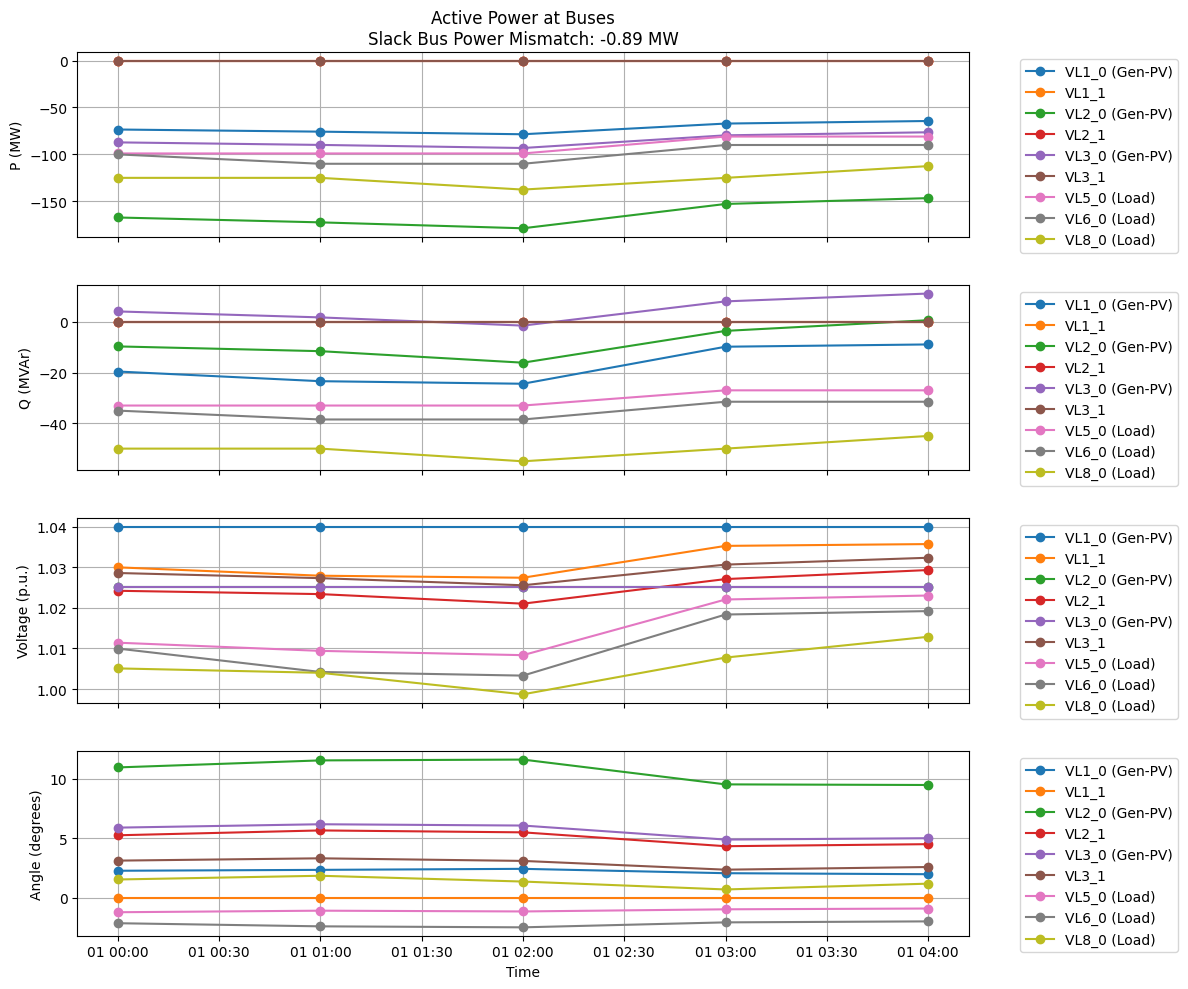

KeyError: "None of ['element_id'] are in the columns"

In [ ]:
# Run with distributed slack using generator current power
results_p = run_power_system_analysis(
    steps=5,
    use_configured_slack=True,
    balance_method='P',
    show_plots=True
)

In [ ]:
# Run with distributed slack using generator margins
results_margin = run_power_system_analysis(
    steps=5,
    use_configured_slack=True,
    balance_method='MARGIN',
    show_plots=False
)

In [ ]:
# Run with distributed slack on loads
results_load = run_power_system_analysis(
    steps=5,
    use_configured_slack=True,
    balance_method='LOAD',
    show_plots=False
)

In [ ]:
line_limits = {
    'L7-8-0': [500,500],  # 500 A permanent limit
    'L9-8-0': [500,500],
    'L7-5-0': [500,500],
    'L9-6-0': [500,500],
    'L5-4-0': [500,500],
    'L6-4-0': [500,500]
}
# Run with distributed slack and line limits
results_l = run_power_system_analysis(
    steps=5,
    use_configured_slack=True,
    balance_method='P',
    line_limits=line_limits,
    show_plots=False
)

## Running Optimal Power flow on the same network:

In [38]:
#improved version of limits with no only permanent limits, and setting limits for all variants (if desired)
def set_line_current_limits(network, line_limits, set_for_all_variants=False):
    """
    Set current limits with different durations and separate limits for each side.
    
    Parameters:
    -----------
    network : Network
        pypowsybl network object
    line_limits : dict
        Dictionary of line limits in format:
        {line_id: [(limit_name, side_one_limit, side_two_limit, duration_seconds), ...]}
        Example: {
            'L7-8-0': [
                ('PERMANENT', 500, 450, -1),
                ('20_MINUTE', 600, 550, 1200)
            ]
        }
    set_for_all_variants : bool, default=False
        If True, sets limits for all variants. If False, only sets for current variant.
    
    Returns:
    --------
    Network
        Updated network with operational limits
    """
    # Store current variant
    original_variant = network.get_working_variant_id()
    
    # Get all variants if needed
    variants_to_update = network.get_network_variants() if set_for_all_variants else [original_variant]
    
    # Prepare data for create_operational_limits
    element_ids = []
    sides = []
    names = []
    types = []
    values = []
    durations = []
    fictitious = []
    
    for line_id, limits in line_limits.items():
        for limit_name, side_one_limit, side_two_limit, duration_seconds in limits:
            # Add side ONE limit
            element_ids.append(line_id)
            sides.append('ONE')
            names.append(limit_name)
            types.append('CURRENT')
            values.append(side_one_limit)
            durations.append(duration_seconds)
            fictitious.append(False)
            
            # Add side TWO limit
            element_ids.append(line_id)
            sides.append('TWO')
            names.append(limit_name)
            types.append('CURRENT')
            values.append(side_two_limit)
            durations.append(duration_seconds)
            fictitious.append(False)
    
    # Apply to all selected variants
    for variant in variants_to_update:
        network.set_working_variant(variant)
        
        # Create operational limits using the direct method with arrays
        network.create_operational_limits(
            element_id=element_ids,
            side=sides,
            name=names,
            type=types,
            value=values,
            acceptable_duration=durations,
            fictitious=fictitious
        )
    
    # Restore original variant
    network.set_working_variant(original_variant)
    return network


In [ ]:
#Not working properly, need attention

def run_time_series_opf(network, snapshots, print_debugging=False):
    """
    Run Optimal Power Flow (OPF) for time series with generator cost optimization
    
    Parameters:
    -----------
    network : Network
        pypowsybl network object
    snapshots : pd.DatetimeIndex
        Time points for simulation
    """
    # Initialize storage
    opf_results = {}
    opf_gen_results = pd.DataFrame(
        index=snapshots,
        columns=pd.MultiIndex.from_product([
            network.get_generators().index,
            ['P_optimized (MW)', 'Cost (€/MWh)']
        ])
    )
    
    opf_objectives = pd.Series(index=snapshots, dtype=float)
    constraint_violations = pd.Series(index=snapshots, dtype=bool)

    # OPF Configuration (Groovy DSL)
    opf_config = '''
    parameters {
        computationType OPF
        lossOfLoadCost 100000  # Very high cost to avoid load shedding
        nbMaxCurativeAction 0  # No post-contingency actions
        objectiveFunction MIN_GENERATION_COST  # Default objective
    }
    '''

    for step in range(len(snapshots)):
        variant_id = f"step_{step}"
        network.set_working_variant(variant_id)
        
        if print_debugging:
            print(f"\n=== Running OPF for timestep {step} ===")
            print("Initial generator setpoints:")
            print(network.get_generators()[['target_p', 'min_p', 'max_p']])

        # Run OPF
        result = pp.securityanalysis.run_scopf(network, opf_config)
        opf_results[step] = result

        # Store results
        gens = network.get_generators()
        for gen_id in gens.index:
            opf_gen_results.loc[snapshots[step], (gen_id, 'P_optimized (MW)')] = gens.loc[gen_id, 'p']
            opf_gen_results.loc[snapshots[step], (gen_id, 'Cost (€/MWh)')] = gens.loc[gen_id, 'marginal_cost']
        
        opf_objectives.loc[snapshots[step]] = result.objective_value
        constraint_violations.loc[snapshots[step]] = result.constraints_violations

        if print_debugging:
            print(f"\nOPF Results for {snapshots[step]}:")
            print(f"Total generation cost: {result.objective_value:.2f} €")
            print("Optimized generation:")
            print(gens[['p', 'target_p', 'min_p', 'max_p']])
            print(f"Constraints violated: {result.constraints_violations}")

        network.set_working_variant("InitialState")
    
    return opf_results, opf_gen_results, opf_objectives, constraint_violations



In [76]:
#Not working properly, need attention
def run_voltage_thermal_opf(network, snapshots):
    """
    Run OPF focusing on voltage stability and line thermal limits with enhanced validation
    """
    # OPF Configuration (Groovy DSL)
    opf_config = '''
    parameters {
        computationType OPF
        objectiveFunction MINIMIZE_VOLTAGE_DEVIATION
        slackDistributionType PROPORTIONAL_TO_GENERATION_PMAX
        distributedSlack false
        readSlackBus true
        
        // Voltage constraints (per unit based on nominal voltage)
        voltageViolationCost 1e6
        voltageRanges [
            { min=0.95, max=1.05 }  // Applies to all buses
        ]
        
        // Thermal constraints
        branchFlowViolationCost 1e6
        branchMonitoring "ALL_BRANCHES"
        
        // Solver settings
        maxIterations 100
        voltageInitMode WARM
        newtonRaphsonConvEpsPer 0.0001
    }
    '''
    
    # Initialize results storage
    results = {}
    voltage_profile = pd.DataFrame(index=snapshots, columns=network.get_buses().index)
    line_utilization = pd.DataFrame(index=snapshots, columns=network.get_lines().index)
    constraint_violations = []

    # Get nominal voltages for reference
    voltage_levels = network.get_voltage_levels()#.set_index('id')
    buses = network.get_buses()
    buses['nominal_v'] = buses['voltage_level_id'].map(voltage_levels['nominal_v'])

    # Get operational limits and process line current limits
    limits_df = network.get_operational_limits()
    line_limits = limits_df[
        (limits_df['element_type'] == 'LINE') & 
        (limits_df['type'] == 'CURRENT')
    ].reset_index()  # Convert index (element_id) to column

    # Create pivot table for line limits
    #line_limits_pivot = line_limits.pivot( # replaced by the line bel
    line_limits = line_limits.pivot(
        index='element_id',
        columns='side',
        values='value'
    ).rename(columns={'ONE': 'current_limit1', 'TWO': 'current_limit2'})

    for step in range(len(snapshots)):
        variant_id = f"step_{step}"
        network.set_working_variant(variant_id)
        
        try:
            # Run security-constrained OPF
            result = pp.securityanalysis.run_scopf(network, opf_config)
            
            if not result.converged:
                raise RuntimeError(f"OPF failed to converge at {snapshots[step]}")
                
            # Store voltage profile in pu
            buses = network.get_buses()
            voltage_profile.loc[snapshots[step]] = buses['v_mag'] / buses['nominal_v']
            
            # Calculate line utilizations
            lines = network.get_lines()
            utilizations = []
            for line_id in lines.index:
                limit1 = line_limits.loc[line_id, 'ONE']
                limit2 = line_limits.loc[line_id, 'TWO']
                utilization = max(
                    lines.loc[line_id, 'i1'] / limit1,
                    lines.loc[line_id, 'i2'] / limit2
                )
                utilizations.append(utilization)
                
            line_utilization.loc[snapshots[step]] = utilizations
            
            # Check for violations
            v_violations = ((voltage_profile.loc[snapshots[step]] < 0.95) | 
                            (voltage_profile.loc[snapshots[step]] > 1.05)).sum()
            t_violations = (line_utilization.loc[snapshots[step]] > 1).sum()
            
            constraint_violations.append({
                'timestamp': snapshots[step],
                'voltage_violations': v_violations,
                'thermal_violations': t_violations,
                'objective_value': result.objective_value
            })
            
        except Exception as e:
            print(f"Error in {variant_id}: {str(e)}")
            constraint_violations.append({
                'timestamp': snapshots[step],
                'error': str(e)
            })
            
        finally:
            network.set_working_variant("InitialState")
    
    return {
        'voltage_profile': voltage_profile,
        'line_utilization': line_utilization,
        'constraint_violations': pd.DataFrame(constraint_violations),
        'raw_results': results
    }



## Optimal Power Flow

### OPF using AMPL solver


#### Some preparations are needed
 Using Knitro solver with AMPL inside the PowSyBl optimizer. This requires to use the Java version, so some additional things are required. 
run these commands in powershell (or in command prompt (cmd) if powershell policies are blocking.... be aware of security issues in cmd...)
The approach includes downloading the JAR files, a java builder and a was intended to use a wrapper to run the java without need for installation. I expected some maven wrapper files for this purpose, but they where not included in the git repo, so i ended up downloading and installing Maven to build the java files
I am using a venv created with UV, so i make sure it is activated (cmd command ".venv/Scripts/activate")
1) 
First download the Powsybl-optimizer files (clone the git repo): cmd: "git clone https://github.com/powsybl/powsybl-optimizer.git"

2) Download a JDK builder, (i have used the one from Adoptium Temuring JDK 21)
Just download it from the web site and unzip in the same directory as you cloned the git repo. I have made a new directory called tools, and included JDK-21 and Powsybl-Optimizer in this folder.
3) Since the git repo did not contain any maven wrapper files i downloaded the binary maven wrapper files from apache maven and unzipped it in the same directory as the JDK and Powsybl-optimizer
go to the directory for powsybl-optimizer and run the command: cmd: "..\apache-maven-3.9.9\bin\mvn clean install -DskipTests"
Make sure the files where unzipped and that the folders contain this path to the mvn
4) create a file (i named it OptimizerNetwork.java) that contains the code to run the optimizer
5) As specified in the getting started section of powsybl-optimizer: change the path to AMPL in the ~.itools\config.yml file

### Attempt to use OpenReac, but this is adandoned as it only optimizes reacitve power (not sufficient for my project)

In [3]:
import pypowsybl.network as pn
import os
import subprocess
import tempfile
import jpype
import jpype.imports

ModuleNotFoundError: No module named 'jpype'

In [86]:
# 1. Create or load your network in pypowsybl
n_for_opf,opf_snapshots = create_ieee9_time_series_network()  
# Add your thermal limits and other configurations here
opf_line_limits = {
    'L7-8-0':[('PERMANENT',500, 500,-1),
              ['1HOUR',700,700,3600]],  # limit name, from-side limit, to-side limit, duration in seconds
    'L9-8-0':[('PERMANeNT',500, 500,-1)],
    'L7-5-0':[('PERMANENT',500, 500,-1)],
    'L9-6-0':[('PERMANENT',500, 500,-1)],
    'L5-4-0':[('PERMANENT',500, 500,-1)],
    'L6-4-0':[('PERMANENT',500, 500,-1)]
}
set_line_current_limits(n_for_opf, opf_line_limits)


Network(id=ieee9cdf, name=ieee9cdf, case_date=2009-04-26 00:00:00+00:00, forecast_distance=0:00:00, source_format=IEEE-CDF)

In [2]:
# 2. Save network to a temporary file in a format Java can read (XIIDM)
temp_dir = tempfile.mkdtemp()
input_file = os.path.join(temp_dir, "network.xiidm")
output_file = os.path.join(temp_dir, "optimized_network.xiidm")
n_for_opf.write_xiidm(input_file)

NameError: name 'tempfile' is not defined

In [ ]:
# 3. Start JVM and import Java classes
if not jpype.isJVMStarted():
    jpype.startJVM(classpath=[
        "/path/to/powsybl-optimizer/target/*",
        "/path/to/powsybl-core/target/*"
        # Add other necessary jars
    ])


In [ ]:
# 4. Import required Java classes
from java.nio.file import Paths
from com.powsybl.iidm.network import Network
from com.powsybl.optimizer.openreac import OpenReacRunner, OpenReacParameters

In [ ]:
# 5. Load network in Java
java_network = Network.read(input_file)

# 6. Configure and run optimization
params = OpenReacParameters()
# Configure parameters as needed
optimizer = OpenReacRunner(params)
result = optimizer.run(java_network)

# 7. Save optimized network
Network.write(java_network, "XIIDM", None, output_file)

In [ ]:
# 8. Load the optimized network back into pypowsybl
optimized_network = pn.load(output_file)

# 9. Visualize the results using pypowsybl-jupyter
from pypowsybl_jupyter import network_explorer
network_explorer(optimized_network)

### Optimizer

### OPF using the Open RAO version

In [33]:
from pypowsybl.rao import Rao as rao
from pypowsybl.rao import Parameters as RaoParameters

## Contingency analysis
Below some ways to do contingency analysis with the built in function in Powsybl is shown.

In [34]:

# Create OpenRAO instance
rao_runner = pp.rao.create_rao()

In [ ]:
#Skip this...
#parameters = RaoParameters()
#parameters.load_from_file_source(input_file_path)
# Create parameters with version 2.4 format
rao_params = {
  "version": "2.4",
  "objective-function": {
    "type": "MAX_MIN_MARGIN_IN_AMPERE"#,
    #"unit": "A"
  }#,
  #"range-actions-optimization": {
  #  "pst-ra-min-impact-threshold": 0.01
  #},
  #"topological-actions-optimization": {
  #  "relative-minimum-impact-threshold": 0.0,
  #  "absolute-minimum-impact-threshold": 1.0
  #}
}
input_file_path="Input/rao_parameters.json"
# Write to file
with open(input_file_path, "w") as f:
    json.dump(rao_params, f, indent=2)


PyPowsyblError: RaoParameters version '3.0' cannot be deserialized. The only supported version currently is '2.4'.

In [36]:
# Create OpenRAO instance
rao_runner = pp.rao.create_rao()

In [39]:
# Define line limits with tuples
line_limits = {
    'L7-8-0':[('PERMANENT',500, 500,-1),
              ['1HOUR',700,700,3600]],  # limit name, from-side limit, to-side limit, duration in seconds
    'L9-8-0':[('PERMANeNT',500, 500,-1)],
    'L7-5-0':[('PERMANENT',500, 500,-1)],
    'L9-6-0':[('PERMANENT',500, 500,-1)],
    'L5-4-0':[('PERMANENT',500, 500,-1)],
    'L6-4-0':[('PERMANENT',500, 500,-1)]
}

n3,snapshots3 = create_ieee9_time_series_network(p_set_gen2=180, p_set_gen3=75, gen_max_p_factor=1.3)
n3 = set_line_current_limits(n3, line_limits)

In [178]:
# check that the limits are set
# After setting limits, verify like this:
limits_df = n3.get_operational_limits()
line_limits = limits_df[
    (limits_df['element_type'] == 'LINE') & 
    (limits_df['type'] == 'CURRENT')
]
print("Current Limits:")
print(line_limits[['name', 'side', 'value']])


Current Limits:
                       name side  value
element_id                             
L7-8-0      permanent_limit  ONE  500.0
L7-8-0                1HOUR  ONE  700.0
L7-8-0      permanent_limit  TWO  500.0
L7-8-0                1HOUR  TWO  700.0
L9-8-0      permanent_limit  ONE  500.0
L9-8-0      permanent_limit  TWO  500.0
L7-5-0      permanent_limit  ONE  500.0
L7-5-0      permanent_limit  TWO  500.0
L9-6-0      permanent_limit  ONE  500.0
L9-6-0      permanent_limit  TWO  500.0
L5-4-0      permanent_limit  ONE  500.0
L5-4-0      permanent_limit  TWO  500.0
L6-4-0      permanent_limit  ONE  500.0
L6-4-0      permanent_limit  TWO  500.0


In [40]:
# we can save the new network to a file so that we can retrieve this later
filename='network3_RAO_test_CIM.xml'
n3.save(os.path.join(SAVE_DIR,filename), format='CGMES')

In [41]:
rao_runner.set_crac_file_source(n3, "Input/crac2.json")


PyPowsyblError: Error while reading json crac, please enable detailed log for more information.

In [ ]:
import io 
try:
    # Make sure you're using the correct network instance 'n3'
    rao_runner.set_crac_file_source(n3, "Input/crac2.json")
    print("CRAC source successfully set")
    
    # 4. Verify the CRAC was set by checking internal state
    # This is a roundabout way to verify - the attempt would fail if no CRAC is set
    with open("Input/crac2.json", "rb") as f:
        crac_buffer = io.BytesIO(f.read())
        # This will throw an error if CRAC source is already set, which is what we want to confirm
        try:
            rao_runner.set_crac_buffer_source(n3, crac_buffer)
            print("Warning: CRAC source wasn't already set")
        except Exception as e:
            if "CRAC source already set" in str(e):
                print("Verified: CRAC source was already set (expected error)")
            else:
                print(f"Unexpected error when checking CRAC state: {e}")
except Exception as e:
    print(f"Error setting CRAC source: {e}")


CRAC source successfully set


In [42]:
import logging
logging.basicConfig(format='%(asctime)s - %(levelname)s - %(message)s')
logging.getLogger('powsybl').setLevel(1)

In [46]:
network = pp.network.create_ieee9()

rao_runner = pp.rao.create_rao()
rao_runner.set_crac_file_source(network, "Input/crac2.json")

rao_result = rao_runner.run(network, parameters)

NameError: name 'parameters' is not defined

In [47]:
# set sources and run
rao_result = rao_runner.run(n3)


2025-04-11 08:57:04,706 - WARNING - Running RAO using Open RAO version 4.8.0 from git commit de884076e9d0cfa1f0975cb9adc227ac23c061b0.
2025-04-11 08:57:04,709 - WARNING - Contingency L9-8-0_outage has an automaton or a curative remedial action but no CNECs associated.
2025-04-11 08:57:04,711 - DEBUG - Systematic sensitivity analysis [start]


2025-04-11 08:57:04,715 - DEBUG - Connected components computed in 0 ms
2025-04-11 08:57:04,719 - DEBUG - LF networks created in 4 ms
2025-04-11 08:57:04,722 - INFO - Network {CC0 SC0} has 9 buses and 9 branches
2025-04-11 08:57:04,722 - INFO - Network {CC0 SC0} balance: active generation=326.64102 MW, active load=315.0 MW, reactive generation=0.0 MVar, reactive load=115.0 MVar
2025-04-11 08:57:04,742 - INFO - Network {CC0 SC0}, slack buses are [VL1_0] (method='Network extension bus')
2025-04-11 08:57:04,747 - INFO - Network {CC0 SC0}, reference bus is VL1_0 (method='First slack')
2025-04-11 08:57:04,752 - INFO - Running AC sensitivity analysis with 18 factors and 1 contingencies
2025-04-11 08:57:04,756 - INFO - Start AC loadflow on network {CC0 SC0}
2025-04-11 08:57:04,760 - DEBUG - Equations index updated (18 columns)
2025-04-11 08:57:04,763 - DEBUG - Variables index updated (18 rows)
2025-04-11 08:57:04,765 - DEBUG - Equation vector updated in 12 us
2025-04-11 08:57:04,769 - DEBUG -

In [ ]:

# Create a security analysis object
security_analysis = pp.security.create_analysis()

# Add contingencies (line outages, generator outages, etc.)
security_analysis.add_single_element_contingency('L7-8-0', 'Line_7_8_Outage')
security_analysis.add_single_element_contingency('L9-8-0', 'Line_9_8_Outage')
security_analysis.add_single_element_contingency('L7-5-0', 'Line_7_5_Outage')
security_analysis.add_single_element_contingency('L9-6-0', 'Line_9_6_Outage')
security_analysis.add_single_element_contingency('L5-4-0', 'Line_5_4_Outage')
security_analysis.add_single_element_contingency('L6-4-0', 'Line_6_4_Outage')
security_analysis.add_monitored_elements(branch_ids=['L7-8-0','L9-8-0','L7-5-0','L9-6-0','L5-4-0', 'L6-4-0' ])
security_analysis.add_monitored_elements(branch_ids=['L7-8-0','L9-8-0','L7-5-0','L9-6-0','L5-4-0', 'L6-4-0' ])
# Run AC security analysis
result = security_analysis.run_ac(n3)

# Examine results
print(result.pre_contingency_result)
print(result.post_contingency_results)
print(result.limit_violations)


In [98]:
#New function to run loadflow with contingencies
def run_time_series_loadflow_with_contingencies(network, snapshots, contingencies=None, monitored_elements=None, print_debugging=False):
    """
    Run load flow and contingency analysis for time series
    
    Parameters:
    -----------
    network : Network
        pypowsybl network object
    snapshots : pd.DatetimeIndex
        Time points for simulation
    contingencies : list, optional
        List of tuples (element_id, contingency_name) to analyze
        Example: [('L7-8-0', 'Line_7_8_Outage'), ('L9-8-0', 'Line_9_8_Outage')]
    monitored_elements : list, optional
        List of branch IDs to monitor during contingency analysis
        If None, all branches will be monitored
    """
    # Initialize storage
    results = {}
    buses = network.get_buses()
    lines = network.get_lines()
    transformers = network.get_2_windings_transformers()
    
    # Initialize DataFrames
    bus_results = pd.DataFrame(
        index=snapshots,
        columns=pd.MultiIndex.from_product([
            buses.index,
            ['P (MW)', 'Q (MVAr)', 'V (pu)', 'Angle (deg)']
        ])
    )
    
    line_results = pd.DataFrame(
        index=snapshots,
        columns=pd.MultiIndex.from_product([
            list(lines.index) + list(transformers.index),
            ['P0 (MW)', 'P1 (MW)', 'Q0 (MVAr)', 'Q1 (MVAr)', 'I1 (A)', 'I2 (A)']
        ])
    )
    
    slack_bus_results = pd.DataFrame(
        index=snapshots,
        columns=['bus_id', 'P_mismatch (MW)', 'distributed_P (MW)']
    )
    
    # Initialize contingency results storage if contingencies are specified
    contingency_results = {}
    if contingencies:
        # Create a security analysis object
        security_analysis = pp.security.create_analysis()
        
        # Add contingencies
        for element_id, contingency_name in contingencies:
            security_analysis.add_single_element_contingency(element_id, contingency_name)
        
        # Add monitored elements if specified
        if monitored_elements:
            security_analysis.add_monitored_elements(branch_ids=monitored_elements)
    
    for step in range(len(snapshots)):
        if print_debugging: print(f"\n=== Processing timestep {step} ===")
        variant_id = f"step_{step}"
        network.set_working_variant(variant_id)
        
        # Get initial generator state
        initial_gens = network.get_generators()
        if print_debugging:
            print("\nInitial generator states:")
            for idx, gen in initial_gens.iterrows():
                print(f"{idx}: P={gen['p']:.2f}, target_P={gen['target_p']:.2f}, "
                    f"voltage_reg={gen['voltage_regulator_on']}")
            
        # Run load flow
        result = pp.loadflow.run_ac(network)
        results[step] = result
        
        # Run contingency analysis if contingencies are specified
        if contingencies:
            if print_debugging:
                print(f"\nRunning contingency analysis for timestep {step}")
            
            # Run security analysis
            security_result = security_analysis.run_ac(network)
            contingency_results[snapshots[step]] = security_result
            
            if print_debugging:
                print(f"Pre-contingency result: {security_result.pre_contingency_result}")
                print(f"Number of post-contingency results: {len(security_result.post_contingency_results)}")
                print(f"Number of limit violations: {len(security_result.limit_violations)}")
        
        # Get updated generator state
        final_gens = network.get_generators()
        if print_debugging:
            print("\nFinal generator states:")
            for idx, gen in final_gens.iterrows():
                print(f"{idx}: P={gen['p']:.2f}, target_P={gen['target_p']:.2f}, "
                    f"voltage_reg={gen['voltage_regulator_on']}")
            
        # Calculate total power change
        total_gen_change = sum(final_gens['p'] - initial_gens['p'])
        
        # Store component results with detailed power tracking
        component_result = result[0]
        if component_result.slack_bus_results:
            slack_info = component_result.slack_bus_results[0]
                        
            slack_bus_results.loc[snapshots[step]] = {
                'bus_id': slack_info.id,
                'P_mismatch (MW)': slack_info.active_power_mismatch,
                'distributed_P (MW)': component_result.distributed_active_power
            }
            
            if print_debugging:
                #For debugging, print the slack bus results
                print(f"\nPower Balance Analysis:")
                print(f"Slack bus: {slack_info.id}")
                print(f"Power mismatch: {slack_info.active_power_mismatch:.2f} MW")
                print(f"Distributed power: {component_result.distributed_active_power:.2f} MW")
                print(f"Total generator change: {total_gen_change:.2f} MW")
                print(f"Load flow status: {component_result.status}")
                
        
        # Store bus results
        for bus_id in buses.index:
            bus = buses.loc[bus_id]
            voltage_level = network.get_voltage_levels()[
                network.get_voltage_levels().index == bus['voltage_level_id']
            ].iloc[0]
            
            bus_results.loc[snapshots[step], (bus_id, 'V (pu)')] = bus['v_mag'] / voltage_level['nominal_v']
            bus_results.loc[snapshots[step], (bus_id, 'Angle (deg)')] = bus['v_angle']
        
        # Store line results
        updated_lines = network.get_lines()
        for line_id in lines.index:
            line = updated_lines.loc[line_id]
            line_results.loc[snapshots[step], (line_id, 'P0 (MW)')] = line['p1']
            line_results.loc[snapshots[step], (line_id, 'P1 (MW)')] = line['p2']
            line_results.loc[snapshots[step], (line_id, 'Q0 (MVAr)')] = line['q1']
            line_results.loc[snapshots[step], (line_id, 'Q1 (MVAr)')] = line['q2']
            line_results.loc[snapshots[step], (line_id, 'I1 (A)')] = line['i1']
            line_results.loc[snapshots[step], (line_id, 'I2 (A)')] = line['i2']
        
        # Store transformer results
        updated_transformers = network.get_2_windings_transformers()
        for trafo_id in transformers.index:
            trafo = updated_transformers.loc[trafo_id]
            line_results.loc[snapshots[step], (trafo_id, 'P0 (MW)')] = trafo['p1']
            line_results.loc[snapshots[step], (trafo_id, 'P1 (MW)')] = trafo['p2']
            line_results.loc[snapshots[step], (trafo_id, 'Q0 (MVAr)')] = trafo['q1']
            line_results.loc[snapshots[step], (trafo_id, 'Q1 (MVAr)')] = trafo['q2']
        
        network.set_working_variant("InitialState")
    
    if contingencies:
        return results, bus_results, line_results, slack_bus_results, contingency_results
    else:
        return results, bus_results, line_results, slack_bus_results


In [ ]:
# Define contingencies
contingencies = [
    ('L7-8-0', 'Line_7_8_Outage'),
    ('L9-8-0', 'Line_9_8_Outage'),
    ('L7-5-0', 'Line_7_5_Outage'),
    ('L9-6-0', 'Line_9_6_Outage'),
    ('L5-4-0', 'Line_5_4_Outage'),
    ('L6-4-0', 'Line_6_4_Outage')
]

# Define monitored elements
monitored_elements = ['L7-8-0', 'L9-8-0', 'L7-5-0', 'L9-6-0', 'L5-4-0', 'L6-4-0']

In [114]:
# Run load flow with contingency analysis
results, bus_results, line_results, slack_results, contingency_results = run_time_series_loadflow_with_contingencies(
    n3, snapshots3, contingencies, monitored_elements, print_debugging=True
)

# Analyze contingency results for each time step
for timestamp, result in contingency_results.items():
    print(f"\n=== Contingency Analysis for {timestamp} ===")
    print(f"Pre-contingency result: {result.pre_contingency_result}")
    
    # Count violations by contingency using the post_contingency_results directly
    for contingency_id, post_result in result.post_contingency_results.items():
        violations = post_result.limit_violations
        print(f"Contingency {contingency_id}: {post_result.status}, {len(violations)} violations")
    
# Find worst contingency (most violations)
if result.post_contingency_results:
    worst_contingency = max(result.post_contingency_results.items(), 
                           key=lambda x: len(x[1].limit_violations))
    print(f"Worst contingency: {worst_contingency[0]} with {len(worst_contingency[1].limit_violations)} violations")


=== Processing timestep 0 ===

Initial generator states:
B1-G: P=-72.01, target_P=71.64, voltage_reg=True
B2-G: P=-180.93, target_P=180.00, voltage_reg=True
B3-G: P=-75.39, target_P=75.00, voltage_reg=True

Running contingency analysis for timestep 0
Pre-contingency result: PreContingencyResult(, status=CONVERGED, limit_violations=[2])
Number of post-contingency results: 6
Number of limit violations: 28

Final generator states:
B1-G: P=-72.01, target_P=71.64, voltage_reg=True
B2-G: P=-180.93, target_P=180.00, voltage_reg=True
B3-G: P=-75.39, target_P=75.00, voltage_reg=True

Power Balance Analysis:
Slack bus: VL1_0
Power mismatch: 0.05 MW
Distributed power: 1.68 MW
Total generator change: 0.00 MW
Load flow status: ComponentStatus.CONVERGED

=== Processing timestep 1 ===

Initial generator states:
B1-G: P=-74.24, target_P=71.64, voltage_reg=True
B2-G: P=-186.54, target_P=180.00, voltage_reg=True
B3-G: P=-77.72, target_P=75.00, voltage_reg=True

Running contingency analysis for timestep